In [1]:
# %pip install scipy
# %pip install opencv-contrib-python
# Force reload of imported modules
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import distance as dist
import math
from scipy import ndimage
from skimage import measure
import numpy as np

In [3]:
from iq_helper import *
from augmentations import *

def get_file_path(iq_number):
    # Convert number (1-10) to file path "iq_images/iq{i}.png" but with a leading zero if i < 10
    return f"iq_images/iq{str(iq_number).zfill(2)}.png"

def get_image(file_path):
    original_image = cv2.imread(file_path)
    return original_image

def get_grayscale_image(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def get_contours(image, isGray = False, isBinary = False, invert = False):
    gray = get_grayscale_image(image) if not isGray else image
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV) if not isBinary else (0, image)
    if invert:
        binary = cv2.bitwise_not(binary)
    contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # it is possible a contour is found around the border of the image, so remove it
    threshold = 0.95
    contours = [contour for contour in contours if cv2.contourArea(contour) / (image.shape[0] * image.shape[1]) < threshold]
    return contours

def align_images(image1, image2, same_shape = False):
    a_contours = get_contours(image1, True, invert=True)
    b_contours = get_contours(image2, True, invert=True)
    # show_image(draw_contours(image1, a_contours))
    a_contours = sorted(a_contours, key=cv2.contourArea, reverse=True)
    b_contours = sorted(b_contours, key=cv2.contourArea, reverse=True)
    x, y, w, h = cv2.boundingRect(a_contours[0])
    image1 = image1[y:y+h, x:x+w]
    x, y, w, h = cv2.boundingRect(b_contours[0])
    image2 = image2[y:y+h, x:x+w]
    if same_shape:
        # Grow the smaller image to the size of the larger image
        if image1.shape[0] > image2.shape[0]:
            image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))
        else:
            image1 = cv2.resize(image1, (image2.shape[1], image2.shape[0]))
    return image1, image2

def remove_background(image1, image2):
    base = cv2.bitwise_and(image1, image2)
    image1 = cv2.bitwise_xor(image1, base)
    image2 = cv2.bitwise_xor(image2, base)
    # clean up the images
    image1 = cv2.medianBlur(image1, 5)
    image2 = cv2.medianBlur(image2, 5)
    return image1, image2

def process_images(image1, image2, align = True, remove_bg = True):
    # Align the images
    if align:
        image1, image2 = align_images(image1, image2, True)
    # Remove the background
    if remove_bg:
        image1, image2 = remove_background(image1, image2)
    else:
        # apply a median blur to the images to remove noise
        image1 = cv2.medianBlur(image1, 5)
        image2 = cv2.medianBlur(image2, 5)
    # convert them to binary images
    image1 = force_to_binary(image1)
    image2 = force_to_binary(image2)
    
    return image1, image2

model = ModelTester()
print("Loaded model")
# for i in range(1, 36):
#     images, choices, answer = get_iq_question_images(i)
#     print(f"Got {len(choices)} choices for IQ {i}")
#     show_images_grid(choices)

# imgs, choices, ans = get_iq_question_images(17)
# print(ans)
# show_images_grid(imgs)
# show_images_grid(choices)
# print([img.shape for img in imgs])
# print([img.shape for img in choices])
# img1, img2 = imgs[0], imgs[1]
# img1, img2 = process_images(img1, img2, align=True, remove_bg=True)
# show_images_grid([img1, img2])

Loaded model


Original and destination images (no background), then with background:
Best angle of 88 with score 0.008264462809917356, next to tried angle of 90 with score 0.009174311926605505
Sample translate by 10: inf


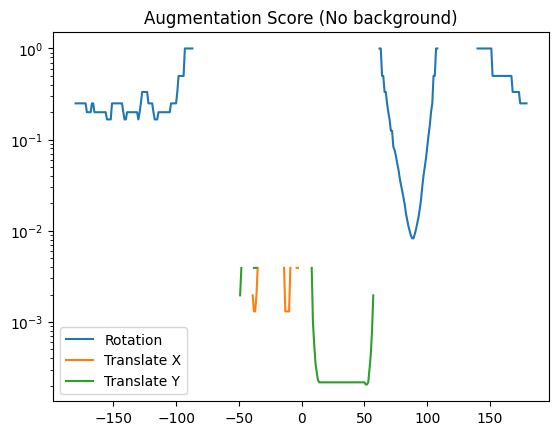

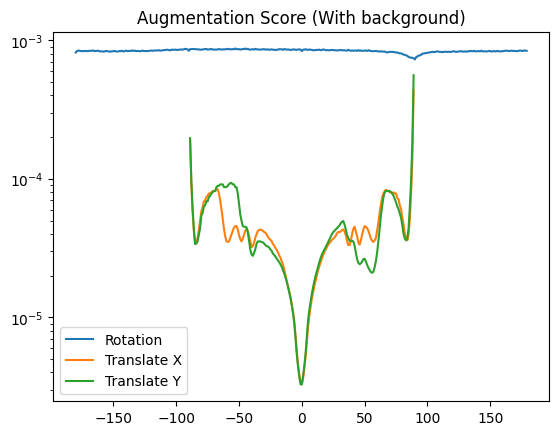

In [4]:
# New approach: Use Gradient Descent or similar to learn the parameters of the augmentation.
# We have base augmentations: Rotate, Flipping, Stretching, Cropping, Color change, and Translation. (Potential: bitwise logic like XOR)

def get_angle(org, dest, partial=None):
    # Try to find the angle that minimizes the difference between the two images
    # We will use the sum of absolute differences as a measure of similarity
    # We will try angles from -180 to 180 in steps of 1 degree
    angles = range(-180, 180)
    best_angle = None
    best_score = float('inf')
    if partial:
        # use a percentage (partial) of the choices
        angles = np.random.choice(angles, int(len(angles) * partial))
    for angle in angles:
        score = augmentation_score(RotateAugmentation(angle), org, dest)
        if score < best_score:
            best_score = score
            best_angle = angle
    # print(f"Best angle: {best_angle}, score: {best_score}")
    return best_angle, best_score
import math

def get_offset(org, dest):
    # Try to find the offset that minimizes the difference between the two images
    # We will use the sum of absolute differences as a measure of similarity
    # We will try offsets from -width to width and -height to height in steps of 1 pixel
    height, width = org.shape[:2]
    best_offset = None
    best_score = float('inf')
    # Randomly sample a tenth of the possible offsets
    offsets = [(dx, dy) for dx in range(-width, width) for dy in range(-height, height)]
    np.random.shuffle(offsets)
    results = {}
    for dx, dy in offsets[:int(len(offsets) / 10)]:
        score = augmentation_score(TranslateAugmentation(dx, dy), org, dest)
        score = math.log(score + 1)
        results[(dx, dy)] = score
        if score < best_score:
            best_score = score
            best_offset = (dx, dy)
    return best_offset, best_score, results

def get_offset_x(org, dest):
    # Try to find the offset that minimizes the difference between the two images
    # We will use the sum of absolute differences as a measure of similarity
    # We will try offsets from -width to width and -height to height in steps of 1 pixel
    height, width = org.shape[:2]
    best_offset = None
    best_score = float('inf')
    for dx in range(-width, width):
        # translated = TranslateAugmentation(dx, 0)(org)
        # score = np.sum(np.abs(translated - dest))
        score = augmentation_score(TranslateAugmentation(dx, 0), org, dest)
        if score < best_score:
            best_score = score
            best_offset = (dx, 0)
    return best_offset, best_score
def get_mirror_angle(org, dest):
    # Try to find the angle that minimizes the difference between the two images
    # We will use the sum of absolute differences as a measure of similarity
    # We will try angles from -180 to 180 in steps of 1 degree
    angles = range(0, 180)
    best_angle = None
    best_score = float('inf')
    for angle in angles:
        flipped = FlipAugmentation(angle)(org)
        score = np.sum(np.abs(flipped - dest))
        if score < best_score:
            best_score = score
            best_angle = angle
    print(f"Best angle: {best_angle}, score: {best_score}")
    return best_angle, best_score

def test_rotation():
    images, _, _ = get_iq_question_images(17)
    org, dest = images[1], images[2]
    org_with_bg, dest_with_bg = org.copy(), dest.copy()
    org_with_bg, dest_with_bg = process_images(org_with_bg, dest_with_bg, remove_bg=False, align=True)
    org, dest = process_images(org, dest, remove_bg=True, align=True)
    print(f"Original and destination images (no background), then with background:")
    # show_images_grid([org, dest, org_with_bg, dest_with_bg])
    # Need them to have the same size
    angle, score = get_angle(org, dest)
    angle_test = 90
    angle_test_score = augmentation_score(RotateAugmentation(angle_test), org, dest)
    print(f"Best angle of {angle} with score {score}, next to tried angle of {angle_test} with score {angle_test_score}")
    aug_img = RotateAugmentation(angle)(org)
    aug_test_img = RotateAugmentation(angle_test)(org)
    # show_images_grid([aug_img, aug_test_img, RotateAugmentation(-90)(org_with_bg), RotateAugmentation(-180)(org_with_bg)])
    print(f"Sample translate by 10: {augmentation_score(TranslateAugmentation(10, 0), org, dest)}")

    # Try plotting the score for different angles, scores for offset x, and scores for offset y
    angles = range(-180, 180)
    rotation_scores = [augmentation_score(RotateAugmentation(angle), org, dest) for angle in angles]
    plt.plot(angles, rotation_scores)
    offset_x = range(-org.shape[1], org.shape[1])
    offset_x_scores = [augmentation_score(TranslateAugmentation(dx, 0), org, dest) for dx in offset_x]
    plt.plot(offset_x, offset_x_scores)
    offset_y = range(-org.shape[0], org.shape[0])
    offset_y_scores = [augmentation_score(TranslateAugmentation(0, dy), org, dest) for dy in offset_y]
    plt.plot(offset_y, offset_y_scores)

    plt.title("Augmentation Score (No background)")
    plt.yscale('log')
    plt.legend(["Rotation", "Translate X", "Translate Y"])
    plt.show()

    angles = range(-180, 180)
    rotation_scores = [augmentation_score(RotateAugmentation(angle), org_with_bg, dest_with_bg) for angle in angles]
    plt.plot(angles, rotation_scores)
    offset_x = range(-org_with_bg.shape[1], org_with_bg.shape[1])
    offset_x_scores = [augmentation_score(TranslateAugmentation(dx, 0), org_with_bg, dest_with_bg) for dx in offset_x]
    plt.plot(offset_x, offset_x_scores)
    offset_y = range(-org_with_bg.shape[0], org_with_bg.shape[0])
    offset_y_scores = [augmentation_score(TranslateAugmentation(0, dy), org_with_bg, dest_with_bg) for dy in offset_y]
    plt.plot(offset_y, offset_y_scores)

    plt.title("Augmentation Score (With background)")
    plt.yscale('log')
    plt.legend(["Rotation", "Translate X", "Translate Y"])
    plt.show()


def test_translation():
    # Testing translation
    images, _ = get_iq_question_images(4)
    org, dest = images[0], images[1]
    org_with_bg, dest_with_bg = org.copy(), dest.copy()
    org_with_bg, dest_with_bg = process_images(org_with_bg, dest_with_bg, remove_bg=False, align=True)
    org, dest = process_images(org, dest, remove_bg=True, align=True)
    print(f"Original and destination images (no background), then with background:")
    show_images_grid([org, dest, org_with_bg, dest_with_bg])
    # Need them to have the same size
    final_offset, score = get_offset_x(org, dest)
    offset_test = -40
    print(f"Best offset of {final_offset} with image, next to tried offset_x of {offset_test}")
    aug_img = TranslateAugmentation(final_offset[0], final_offset[1])(org)
    aug_test_img = TranslateAugmentation(offset_test, 0)(org)
    show_images_grid([aug_img, aug_test_img])
    
    # Try plotting the score for different angles, scores for offset x, and scores for offset y
    angles = range(-180, 180)
    rotation_scores = [augmentation_score(RotateAugmentation(angle), org, dest) for angle in angles]
    plt.plot(angles, rotation_scores)
    offset_x = range(-org.shape[1], org.shape[1])
    offset_x_scores = [augmentation_score(TranslateAugmentation(dx, 0), org, dest) for dx in offset_x]
    plt.plot(offset_x, offset_x_scores)
    offset_y = range(-org.shape[0], org.shape[0])
    offset_y_scores = [augmentation_score(TranslateAugmentation(0, dy), org, dest) for dy in offset_y]
    plt.plot(offset_y, offset_y_scores)

    plt.title("Augmentation Score (No background)")
    plt.yscale('log')
    plt.legend(["Rotation", "Translate X", "Translate Y"])
    plt.show()

    angles = range(-180, 180)
    rotation_scores = [augmentation_score(RotateAugmentation(angle), org_with_bg, dest_with_bg) for angle in angles]
    plt.plot(angles, rotation_scores)
    offset_x = range(-org_with_bg.shape[1], org_with_bg.shape[1])
    offset_x_scores = [augmentation_score(TranslateAugmentation(dx, 0), org_with_bg, dest_with_bg) for dx in offset_x]
    plt.plot(offset_x, offset_x_scores)
    offset_y = range(-org_with_bg.shape[0], org_with_bg.shape[0])
    offset_y_scores = [augmentation_score(TranslateAugmentation(0, dy), org_with_bg, dest_with_bg) for dy in offset_y]
    plt.plot(offset_y, offset_y_scores)

    plt.title("Augmentation Score (With background)")
    plt.yscale('log')
    plt.legend(["Rotation", "Translate X", "Translate Y"])
    plt.show()

def test_translation_xy():
    images, _ = get_iq_question_images(4)
    org, dest = images[3], images[4]
    org_with_bg, dest_with_bg = org.copy(), dest.copy()
    org_with_bg, dest_with_bg = process_images(org_with_bg, dest_with_bg, remove_bg=False, align=True)
    org, dest = process_images(org, dest, remove_bg=True, align=True)
    show_images_grid([org, dest, org_with_bg, dest_with_bg])
    final_offset, score, results = get_offset(org, dest)
    test_offset = (-40, 40)
    print(f"Best offset found with {final_offset} and score {score}. Trying test offset of {test_offset}")
    aug_img = TranslateAugmentation(final_offset[0], final_offset[1])(org)
    aug_test_img = TranslateAugmentation(test_offset[0], test_offset[1])(org)
    final_offset, score, results_with_bg = get_offset(org_with_bg, dest_with_bg)
    print(f"Best offset found with {final_offset} and score {score} (with background). Trying test offset of {test_offset}")
    aug_img_with_bg = TranslateAugmentation(final_offset[0], final_offset[1])(org_with_bg)
    aug_test_img_with_bg = TranslateAugmentation(test_offset[0], test_offset[1])(org_with_bg)
    show_images_grid([aug_img, aug_test_img, aug_img_with_bg, aug_test_img_with_bg])

    # Plot the scores for the different offsets
    x = []
    y = []
    z = []
    for offset, score in results.items():
        x.append(offset[0])
        y.append(offset[1])
        z.append(score)
    # Create heatmap
    plt.scatter(x, y, c=z, cmap='viridis')
    plt.colorbar()
    plt.title("Augmentation Score")
    plt.xlabel("Offset X (pixels)")
    plt.ylabel("Offset Y (pixels)")
    plt.show()
    
    x = []
    y = []
    z = []
    for offset, score in results_with_bg.items():
        x.append(offset[0])
        y.append(offset[1])
        z.append(score)
    # Create heatmap
    plt.scatter(x, y, c=z, cmap='viridis')
    plt.colorbar()
    plt.title("Augmentation Score")
    plt.xlabel("Offset X (pixels)")
    plt.ylabel("Offset Y (pixels)")
    plt.show()


def plot_different_augmentations():
    data = iq_test_to_squares(get_image('iq_images/iq17.png'))
    org = data[1]
    dest = data[2]
    
    org, dest = process_images(org, dest, remove_bg=True)
    show_image(org)
    show_image(dest)
    angles = range(-180, 180)
    scores = [augmentation_score(RotateAugmentation(angle), org, dest) for angle in angles]
    plt.title("Rotation score")
    plt.plot(angles, scores)
    plt.xlabel("Angle (degrees)")
    plt.show()
    offset_x = range(-org.shape[1], org.shape[1])
    scores = [augmentation_score(TranslateAugmentation(dx, 0), org, dest) for dx in offset_x]
    plt.title("Translation X score")
    plt.plot(offset_x, scores)
    plt.xlabel("Offset (pixels)")
    plt.show()
    offset_y = range(-org.shape[0], org.shape[0])
    scores = [augmentation_score(TranslateAugmentation(0, dy), org, dest) for dy in offset_y]
    plt.title("Translation Y score")
    plt.plot(offset_y, scores)
    plt.xlabel("Offset (pixels)")
    plt.show()

    # try translate x by 60
    aug_img = TranslateAugmentation(60, 0)(org)
    show_image(aug_img)
    # try translate y by 72
    aug_img = TranslateAugmentation(0, 72)(org)
    show_image(aug_img)
    # try translate y by -90
    aug_img = TranslateAugmentation(0, -90)(org)
    show_image(aug_img)
    
test_rotation()
# test_translation()
# test_translation_xy()
# plot_different_augmentations()




# images, _ = get_iq_question_images(17)
# org, dest = images[1], images[2]
# org_with_bg, dest_with_bg = org.copy(), dest.copy()
# org_with_bg, dest_with_bg = process_images(org_with_bg, dest_with_bg, remove_bg=False, align=True)
# org, dest = process_images(org, dest, remove_bg=False, align=True)
# show_images_grid([org, dest])
# aligned_img, similarity = warp_image(org, dest)
# print(f"Similarity: {similarity}")
# show_images_grid([aligned_img, dest])

In [39]:
def try_spread(org, dest, init_params, spread, partial=None):
    best_params = init_params
    best_score = augmentation_score(RotateTranslateAugmentation(*init_params), org, dest)
    spread = 10
    xrange = range(-spread, spread)
    yrange = range(-spread, spread)
    rrange = range(-spread, spread)
    if partial:
        xrange = np.random.choice(xrange, int(2 * spread * partial))
        yrange = np.random.choice(yrange, int(2 * spread * partial))
        rrange = np.random.choice(rrange, int(2 * spread * partial))

    for dx in xrange:
        for dy in yrange:
            for dr in rrange:
                new_params = (init_params[0] + dr, init_params[1] + dx, init_params[2] + dy)
                score = augmentation_score(RotateTranslateAugmentation(*new_params), org, dest)
                if score < best_score:
                    best_score = score
                    best_params = new_params
    return best_params, best_score

def get_rotation_translation(org, dest):
    # Try to find the angle that minimizes the difference between the two images
    # We will use the sum of absolute differences as a measure of similarity
    # We will try angles from -180 to 180 in steps of 1 degree
    angles = range(-180, 180, 10)
    best_params = None
    best_score = float('inf')
    dest_center = cv2.moments((dest > 0).astype(np.uint8) * 255)
    dest_x = int(dest_center["m10"] / dest_center["m00"])
    dest_y = int(dest_center["m01"] / dest_center["m00"])
    for angle in angles:
        rotated = RotateAugmentation(angle)(org)
        aug_center = cv2.moments((rotated > 0).astype(np.uint8) * 255)
        aug_center_x = int(aug_center["m10"] / aug_center["m00"]) if aug_center["m00"] > 0 else 0
        aug_center_y = int(aug_center["m01"] / aug_center["m00"]) if aug_center["m00"] > 0 else 0
        dx = dest_x - aug_center_x
        dy = dest_y - aug_center_y
        score = augmentation_score(RotateTranslateAugmentation(angle, dx, dy), org, dest)
        if score < best_score:
            best_score = score
            best_params = (angle, dx, dy)
    # find the spread on the best params
    best_params, best_score = try_spread(org, dest, best_params, 10)
    return best_params, best_score

def get_rotation_translation_slow(org, dest):
    init_angle, best_score = get_angle(org, dest, partial=0.3)
    best_params = (init_angle, 0, 0)
    tries = [best_params]
    best_params, best_score = try_spread(org, dest, best_params, 10, partial=0.3)
    tries.append(best_params)
    best_params, best_score = try_spread(org, dest, best_params, 2)
    tries.append(best_params)
    print(tries)
    return best_params, best_score

def test_all_rotations():
    transitions = [(0, 1), (1, 2), (3, 4), (4, 5), (6, 7)]
    images, _, _ = model.get_question(17)
    print("For iq test 17, rotating dials (45, then 90 degree rotations)")
    for org_idx, dest_idx in transitions:
        org, dest = images[org_idx], images[dest_idx]
        org, dest = process_images(org, dest, remove_bg=False, align=False)
        best_params, best_score = get_rotation_translation(org, dest)
        print(f"From {org_idx} to {dest_idx}, best params: {best_params}, score: {best_score}")
    images, _, _ = model.get_question(5)
    print("\nFor iq test 5, rotating arrows (Rule: 45 each time)")
    for org_idx, dest_idx in transitions:
        org, dest = images[org_idx], images[dest_idx]
        org, dest = process_images(org, dest, remove_bg=False, align=False)
        best_params, best_score = get_rotation_translation(org, dest)
        print(f"From {org_idx} to {dest_idx}, best params: {best_params}, score: {best_score}")
    images, _, _ = model.get_question(10)
    print("\nFor iq test 10, rotating arrowheads (Rule: -90 each time)")
    for org_idx, dest_idx in transitions:
        org, dest = images[org_idx], images[dest_idx]
        org, dest = process_images(org, dest, remove_bg=False, align=False)
        best_params, best_score = get_rotation_translation(org, dest)
        print(f"From {org_idx} to {dest_idx}, best params: {best_params}, score: {best_score}")
    test_sample = False
    if test_sample:
        org, dest = images[6], images[7]
        org, dest = process_images(org, dest, remove_bg=False, align=False)
        best_params, best_score = get_rotation_translation(org, dest)
        best_angle, best_dx, best_dy = best_params
        best_aug = RotateTranslateAugmentation(best_angle, best_dx, best_dy)(org)
        test_augmentation_params = (45, 0, 0)
        test_augmentation = RotateTranslateAugmentation(*test_augmentation_params)
        test_aug = test_augmentation(org)
        print(f"Found best params: {best_params}, score: {best_score}")
        print(f"Test params {test_augmentation_params} had score: {augmentation_score(test_augmentation, org, dest)}")
        show_images_grid([org, dest, get_overlap(dest, best_aug), get_overlap(dest, test_aug)])
test_all_rotations()


For iq test 17, rotating dials (45, then 90 degree rotations)
From 0 to 1, best params: (44, 4, 4), score: 2.877557069150574e-06
From 1 to 2, best params: (89, 6, 5), score: 2.9536774761416703e-06
From 3 to 4, best params: (45, -1, 0), score: 2.9174422200568317e-06
From 4 to 5, best params: (79, 3, 3), score: 3.205981078299676e-06
From 6 to 7, best params: (42, 5, 2), score: 2.8967119422743244e-06

For iq test 5, rotating arrows (Rule: 45 each time)
From 0 to 1, best params: (45, 0, 6), score: 7.146532502429821e-06
From 1 to 2, best params: (45, 7, -2), score: 7.344246884203259e-06
From 3 to 4, best params: (45, 1, 6), score: 7.2294034296289874e-06
From 4 to 5, best params: (45, 1, 3), score: 7.423574302555194e-06
From 6 to 7, best params: (45, 6, 3), score: 7.789011262910287e-06

For iq test 10, rotating arrowheads (Rule: -90 each time)
From 0 to 1, best params: (-89, -3, -3), score: 2.4582104228121927e-06
From 1 to 2, best params: (-91, -5, -2), score: 2.482664793082303e-06
From 3 to

In [6]:
# Initial attempt, choose the choice with the closest rule to what we predict
def get_prediction():
    images, choices, answer = model.get_question(17)
    # given a list of transitions in the grid, choose the best choice from choices
    transitions = [(0, 1), (1, 2), (3, 4), (4, 5), (6, 7)]
    params = []
    for org_idx, dest_idx in transitions:
        org, dest = images[org_idx], images[dest_idx]
        org, dest = process_images(org, dest, remove_bg=False, align=False)
        best_params, best_score = get_rotation_translation(org, dest)
        params.append(best_params)
    # How similar are they? If they are the same, use this rule for the next image
    print(params)
    avg_rotation = sum([param[0] for param in params]) / len(params)
    # is each rotation similar?
    use_avg_rotation = False
    if all([abs(param[0] - avg_rotation) < 10 for param in params]):
        # use the average rotation
        use_avg_rotation = True
    if use_avg_rotation:
        print("Using constant rotations")
        # get the score of each choice
        scores = []
        for i, choice in enumerate(choices):
            org, dest = process_images(images[7], choice, remove_bg=False, align=True)
            best_params, best_score = get_rotation_translation(org, dest)
            print(f"Potential choice {i} has params {best_params} with score {best_score}")
            scores.append(abs(best_params[0] - avg_rotation))
        print(scores)
        # choose the choice with the lowest score
        choice = np.argmin(scores)
        print(f"Chose choice {choice} with score {scores[choice]}, correct answer is {answer}")
    else:
        # might be a different pattern of rotation, or something else
        # Might be alternating rotations
        group1 = range(0, 5, 2)
        group2 = range(1, 5, 2)
        rotation1 = sum([params[i][0] for i in group1]) / 3
        all_same1 = all([abs(params[i][0] - rotation1) < 10 for i in group1])
        rotation2 = sum([params[i][0] for i in group2]) / 2
        all_same2 = all([abs(params[i][0] - rotation2) < 10 for i in group2])
        print(f"Rotations: {rotation1}, {rotation2}, {all_same1} and {all_same2}")
        if all_same1 and all_same2:
            print("Using alternating rotations")
            # alternating rotations
            scores = []
            for choice in choices:
                org, dest = process_images(images[7], choice, remove_bg=False, align=False)
                best_params, best_score = get_rotation_translation(org, dest)
                scores.append(abs(best_params[0] - rotation1))
            print(scores)
            # choose the choice with the lowest score
            choice = np.argmin(scores)
            print(f"Chose choice {choice} with score {scores[choice]}, correct answer is {answer}")
        else:
            print("No pattern found")
get_prediction()

[(44, 4, 4), (89, 6, 5), (45, -1, 0), (79, 3, 3), (42, 5, 2)]
Rotations: 43.666666666666664, 84.0, True and True
Using alternating rotations
[173.66666666666666, 5.333333333333336, 53.666666666666664, 36.333333333333336, 233.66666666666666, 93.33333333333334]
Chose choice 1 with score 5.333333333333336, correct answer is 3


In [37]:
# generating new predicted images
print("Generating predicted image, and comparing similarities")
def generate_rotate_prediction(images, remove_bg=False, align=True):
    # given a list of transitions in the grid, choose the best choice from choices
    transitions = [(0, 1), (1, 2), (3, 4), (4, 5), (6, 7)]
    params = []
    for org_idx, dest_idx in transitions:
        org, dest = images[org_idx], images[dest_idx]
        org, dest = process_images(org, dest, remove_bg=remove_bg, align=align)
        best_params, best_score = get_rotation_translation(org, dest)
        params.append(best_params)
    # How similar are they? If they are the same, use this rule for the next image
    print(params)
    avg_rotation = sum([param[0] for param in params]) / len(params)
    # is each rotation similar?
    use_avg_rotation = False
    if all([abs(param[0] - avg_rotation) < 10 for param in params]):
        # use the average rotation
        use_avg_rotation = True
    if use_avg_rotation:
        print(f"Using constant rotations of {avg_rotation}")
        predicted = RotateAugmentation(avg_rotation)(images[7])
        return predicted
    else:
        # might be a different pattern of rotation, or something else
        # Might be alternating rotations
        group1 = range(0, 5, 2)
        group2 = range(1, 5, 2)
        rotation1 = sum([params[i][0] for i in group1]) / 3
        all_same1 = all([abs(params[i][0] - rotation1) < 10 for i in group1])
        rotation2 = sum([params[i][0] for i in group2]) / 2
        all_same2 = all([abs(params[i][0] - rotation2) < 10 for i in group2])
        print(f"Rotations: {rotation1}, {rotation2}, {all_same1} and {all_same2}")
        if all_same1 and all_same2:
            print(f"Using alternating rotations of {rotation2}")
            predicted = RotateTranslateAugmentation(rotation2, 0, 0)(images[7])
            return predicted
        else:
            print("No pattern found")
            return None
images, choices, answer = model.get_question(17)
predicted = generate_rotate_prediction(images)
scores = []
for choice in choices:
    scores.append(loss(choice, predicted))
print(scores)
# choose the choice with the lowest score
choice = np.argmin(scores)
print(f"Chose choice {choice} with score {scores[choice]}, correct answer is {answer}")

Generating predicted image, and comparing similarities
[(45, 0, 0), (90, -1, -1), (45, -1, 0), (90, -1, 1), (42, -1, 1)]
Rotations: 44.0, 90.0, True and True
Using alternating rotations of 90.0
[5.443954488540476e-05, 6.506180871828237e-05, 7.68344218209758e-05, 2.7645692801061596e-05, 6.784720808738721e-05, 6.967670011148272e-05]
Chose choice 3 with score 2.7645692801061596e-05, correct answer is 3


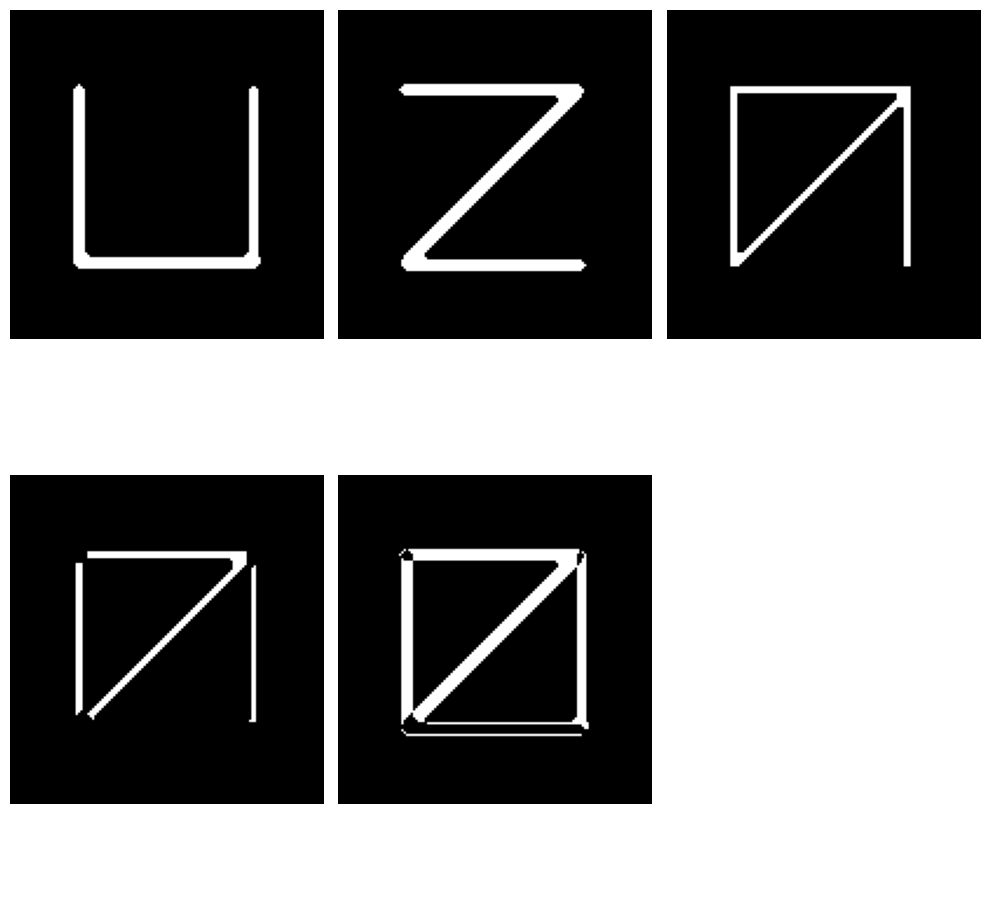

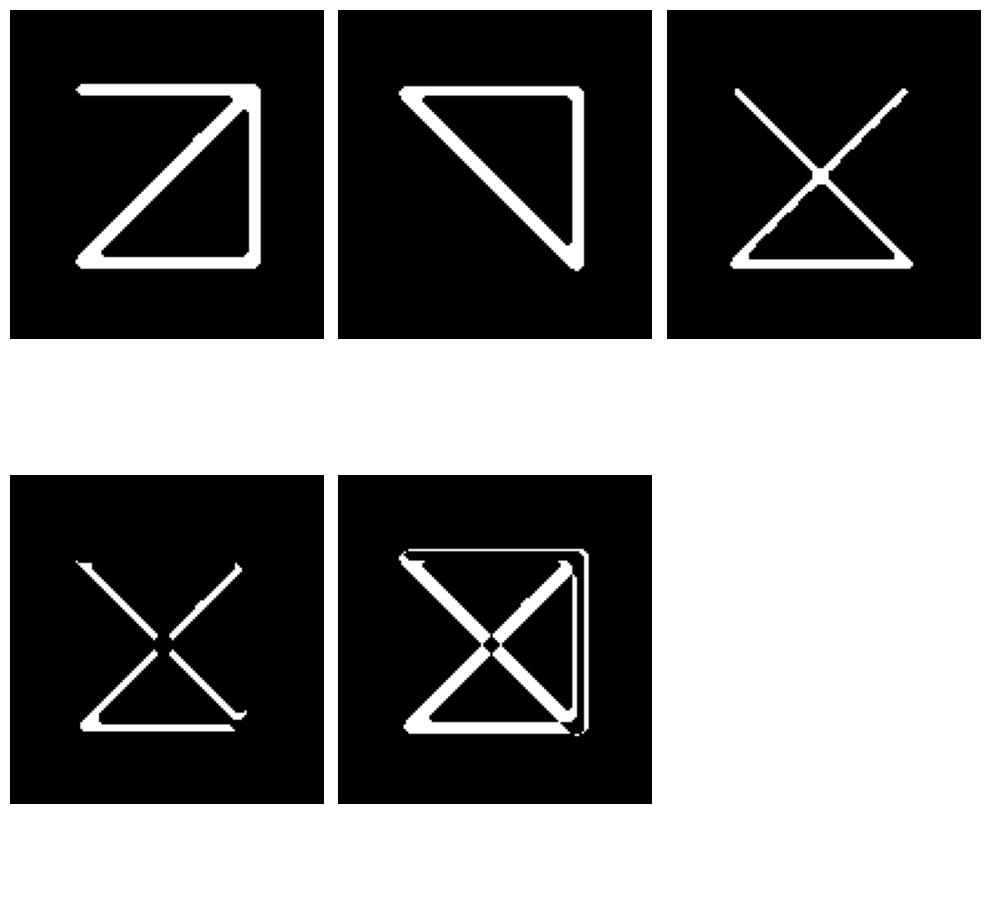

In [34]:
# try bitwise
images, choices, answer = model.get_question(20)
bitwise_combinations = [(0, 1, 2), (3, 4, 5)]
for combo in bitwise_combinations:
    xor_in1 = images[combo[0]]
    xor_in2 = images[combo[1]]
    xor_out = images[combo[2]]
    # dilate inputs
    xor_in1 = cv2.dilate(xor_in1, np.ones((3, 3), np.uint8), iterations=1)
    xor_in2 = cv2.dilate(xor_in2, np.ones((3, 3), np.uint8), iterations=1)
    xor_in1, xor_in2 = process_images(xor_in1, xor_in2, remove_bg=False, align=False)
    xor_teste = cv2.bitwise_xor(xor_in1, xor_in2)
    # erode edges
    xor_test = cv2.erode(xor_teste, np.ones((3, 3), np.uint8), iterations=1)
    # dilate and erode output
    xor_out = cv2.dilate(xor_out, np.ones((3, 3), np.uint8), iterations=1)
    xor_out = cv2.erode(xor_out, np.ones((3, 3), np.uint8), iterations=1)
    show_images_grid([xor_in1, xor_in2, xor_out, xor_test, xor_teste])

Predicting for question 4
[(-180, 28, -1), (-180, -33, -2), (0, -21, 30), (0, -23, 22), (-180, 0, -31)]
Rotations: -120.0, -90.0, False and False
No pattern found
[(-180, 30, 0), (-180, -31, 0), (-120, 23, 8), (2, -19, 17), (-180, 0, -30)]
Rotations: -160.0, -89.0, False and False
No pattern found
[(0, -40, 0), (0, -37, 0), (4, -25, 32), (0, -26, 26), (0, 2, 39)]
Using constant rotations of 0.8
[(0, -38, 0), (-180, -40, 0), (-178, 22, -22), (-1, -22, 23), (0, 0, 40)]
Rotations: -59.333333333333336, -90.5, False and False
No pattern found
Predicted Bitwise:


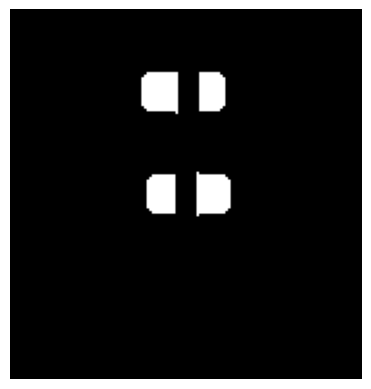

Correct answer 5


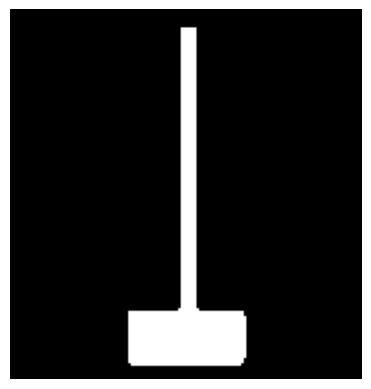

Question 4 - Predicted 1, actual 5
Predicting for question 5
[(45, 0, 6), (45, 7, -2), (45, 1, 6), (45, 1, 3), (45, 6, 3)]
Using constant rotations of 45.0
[(-157, 2, -8), (47, -3, -1), (23, 2, -2), (43, 3, -1), (22, 4, -11)]
Rotations: -37.333333333333336, 45.0, False and True
No pattern found
[(45, 0, 6), (45, 7, -2), (45, 1, 6), (45, 1, 3), (45, 6, 3)]
Using constant rotations of 45.0
[(23, 1, -2), (47, -3, -1), (-156, 0, -3), (42, 2, -2), (25, 2, -6)]
Rotations: -36.0, 44.5, False and True
No pattern found
Predicted Bitwise:


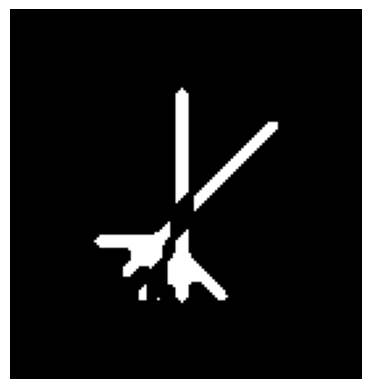

Predicted Rotate (no align):


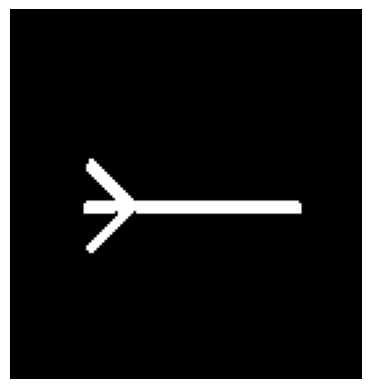

Correct answer 3


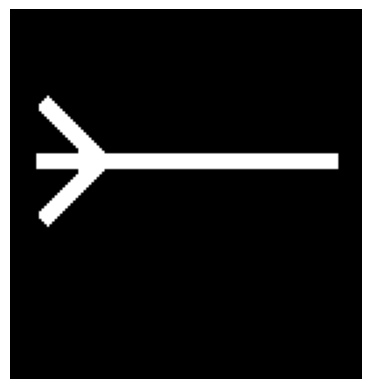

Question 5 - Predicted 4, actual 3
Predicting for question 10
[(-89, -3, -3), (-91, -5, -2), (-91, 5, -1), (-90, 0, 2), (-90, 2, -1)]
Using constant rotations of -90.2
[(-86, -3, -1), (-94, -1, -3), (-86, 0, 1), (-94, 0, -2), (-85, 1, -1)]
Using constant rotations of -89.0
[(-91, -7, -5), (-91, -6, -1), (-91, 6, 0), (-91, 3, 0), (-90, 2, -1)]
Using constant rotations of -90.8
[(-87, -6, -4), (-95, -3, 0), (-80, 5, 1), (-95, 2, -4), (-73, -1, 10)]
Rotations: -80.0, -95.0, True and True
Using alternating rotations of -95.0
Predicted Bitwise:


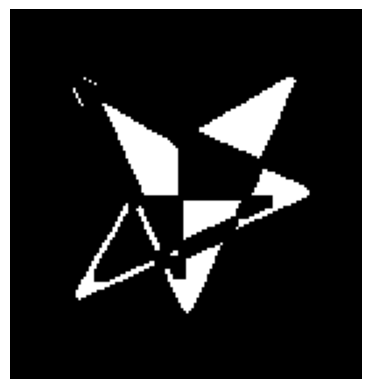

Predicted Rotate (no align):


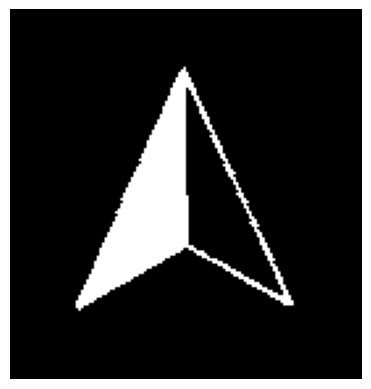

Predicted Rotate (align):


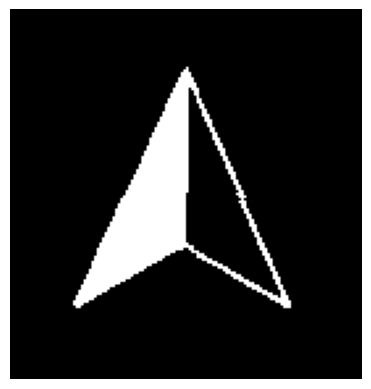

Correct answer 3


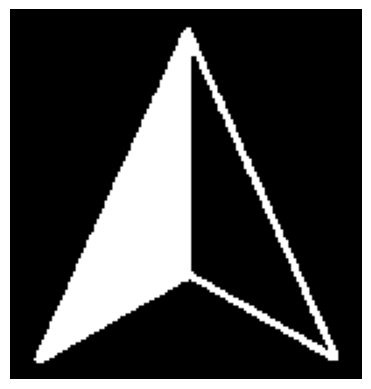

Question 10 - Predicted 3, actual 3
Predicting for question 17
[(44, 4, 4), (89, 6, 5), (45, -1, 0), (79, 3, 3), (42, 5, 2)]
Rotations: 43.666666666666664, 84.0, True and True
Using alternating rotations of 84.0
[(45, 0, 0), (90, -1, -1), (45, -1, 0), (90, -1, 1), (42, -1, 1)]
Rotations: 44.0, 90.0, True and True
Using alternating rotations of 90.0
[(39, 7, 3), (88, 5, 5), (45, 2, 3), (-89, -37, 34), (45, 6, -1)]
Rotations: 43.0, -0.5, True and False
No pattern found
[(45, 0, 0), (-90, 32, 33), (45, 0, 1), (90, -1, 1), (-136, 0, 44)]
Rotations: -15.333333333333334, 0.0, False and False
No pattern found
Predicted Bitwise:


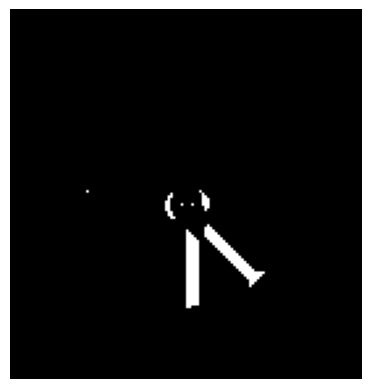

Predicted Rotate (no align):


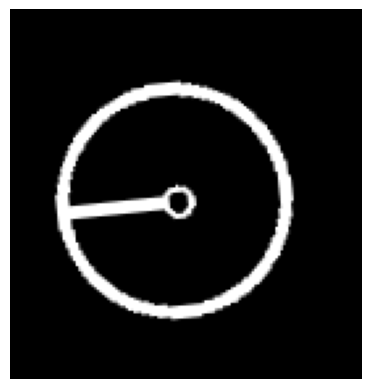

Predicted Rotate (align):


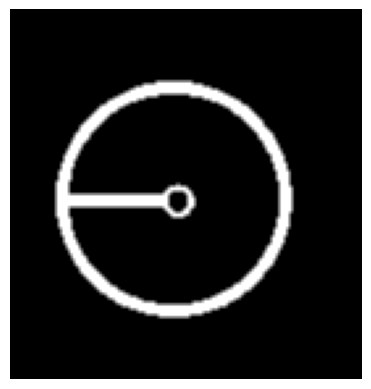

Correct answer 3


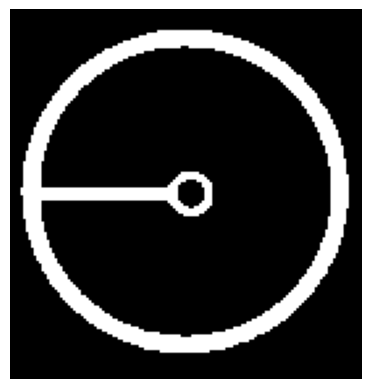

Question 17 - Predicted 3, actual 3
Predicting for question 20
[(-61, -19, -23), (89, -1, 2), (-91, 4, 8), (89, -1, 3), (-180, 0, -3)]
Rotations: -110.66666666666667, 89.0, False and True
No pattern found
[(83, 17, 26), (-90, 0, -1), (-80, 3, -3), (91, -2, 0), (-180, -1, -1)]
Rotations: -59.0, 0.5, False and False
No pattern found


TypeError: augmentations.RotateTranslateAugmentation() argument after * must be an iterable, not NoneType

In [40]:
def get_bitwise_prediction(images):
    xor_in1 = images[6]
    xor_in2 = images[7]
    # dilate inputs
    xor_in1 = cv2.dilate(xor_in1, np.ones((3, 3), np.uint8), iterations=1)
    xor_in2 = cv2.dilate(xor_in2, np.ones((3, 3), np.uint8), iterations=1)
    xor_in1, xor_in2 = process_images(xor_in1, xor_in2, remove_bg=False, align=False)
    xor_out = cv2.bitwise_xor(xor_in1, xor_in2)
    xor_out = cv2.erode(xor_out, np.ones((3, 3), np.uint8), iterations=1)
    return xor_out
def get_prediction(images, choices):
    # choose the choice with the closest similarity to a prediction
    bitwise_pred = get_bitwise_prediction(images)
    rotate_translate_pred_noalign = generate_rotate_prediction(images, align=False)
    rotate_translate_pred_align = generate_rotate_prediction(images, align=True)
    rotate_translate_pred_noalign_nobg = generate_rotate_prediction(images, align=False, remove_bg=True)
    rotate_translate_pred_align_nobg = generate_rotate_prediction(images, align=True, remove_bg=True)
    best_score = float('inf')
    best_choice = None
    for prediction_image, name in zip([bitwise_pred, rotate_translate_pred_noalign, rotate_translate_pred_align], ["Bitwise", "Rotate (no align)", "Rotate (align)"]):
        if prediction_image is not None:
            print(f"Predicted {name}:")
            show_image(prediction_image)
    for i, choice in enumerate(choices):
        for prediction in [bitwise_pred, rotate_translate_pred_noalign, rotate_translate_pred_align, rotate_translate_pred_noalign_nobg, rotate_translate_pred_align_nobg]:
            score = loss(choice, prediction)
            if score < best_score:
                best_score = score
                best_choice = i
    return best_choice

correct = 0
total = 0
for qid in [4, 5, 10, 17, 20, 21]:
    print(f"Predicting for question {qid}")
    images, choices, answer = model.get_question(qid)
    prediction = get_prediction(images, choices)
    print(f"Correct answer {answer}")
    show_image(choices[answer])
    print(f"Question {qid} - Predicted {prediction}, actual {answer}")
    if prediction == answer:
        correct += 1
    total += 1

print(f"Got {correct} correct out of {total}")

In [9]:
# Gradient descent (or sort of like binary search?) to find the optimal angle, offset, or other parameters

def gradient_descent(create_augmentation, parameter_range, org, dest, debug=False):
    tried_x = []
    tried_y = []
    def score(parameter):
        score = augmentation_score(create_augmentation(parameter), org, dest)
        tried_x.append(parameter)
        tried_y.append(score)
        return score
    start, stop = parameter_range
    golden_ratio = (1 + 5 ** 0.5) / 2
    max_iterations = 100
    tolerance = 3
    for _ in range(max_iterations):
        if debug:
            print(f"Range: {start} - {stop}")
        range_size = stop - start
        if range_size < tolerance:
            break

        mid1 = stop - range_size / golden_ratio
        mid2 = start + range_size / golden_ratio
        # these must be integers
        mid1 = round(mid1)
        mid2 = round(mid2)

        score1 = score(mid1)
        score2 = score(mid2)

        if score1 < score2:
            stop = mid2
        else:
            start = mid1

    optimal_parameter = (start + stop) / 2
    return optimal_parameter, (tried_x, tried_y)

def gradient_descent_2(create_augmentation, parameter_range, org, dest, debug=False):
    tried_x = []
    tried_y = []
    def score(parameter):
        score = augmentation_score(create_augmentation(parameter), org, dest)
        tried_x.append(parameter)
        tried_y.append(score)
        return score
    def avg_score(parameter):
        return np.mean([score(parameter + dx) for dx in [-1, 0, 1]])
    # The idea of this is two try nearby parameters to determine the direction to go
    start, stop = parameter_range
    def converge(init):
        current = init
        max_iterations = 20
        for _ in range(max_iterations):
            current_score = avg_score(current)
            nearby = [current - 10, current + 10]
            nearby_scores = [avg_score(n) for n in nearby]
            if current_score < nearby_scores[0] and current_score < nearby_scores[1]:
                return current, current_score
            if nearby_scores[0] < nearby_scores[1]:
                current = nearby[0]
            else:
                current = nearby[1]
        return current, current_score
    # Try different random initializations
    best_score = float('inf')
    best_parameter = None
    for _ in range(5):
        init = np.random.uniform(start, stop)
        init = round(init)
        parameter, this_score = converge(init)
        if this_score < best_score:
            best_score = this_score
            best_parameter = parameter
    return best_parameter, (tried_x, tried_y)   

# Use gradient_descent to find the best score and parameters for each type of augmentation, and choose the best
def learn_parameters(org, dest):
    # The augmentation could be any of the base augmentations
    augmentations = [RotateAugmentation, lambda dx: TranslateAugmentation(dx, 0), lambda dy: TranslateAugmentation(0, dy)]
    names = ["Rotate", "Translate X", "Translate Y"]
    parameters = [(-180, 180), (-org.shape[1], org.shape[1]), (-org.shape[0], org.shape[0])]
    best_score = float('inf')
    best_result = None
    for name, create_augmentation, parameter_range in zip(names, augmentations, parameters):
        optimal_parameter, _ = gradient_descent(create_augmentation, parameter_range, org, dest)
        optimal_parameter = round(optimal_parameter)
        score = augmentation_score(create_augmentation(optimal_parameter), org, dest)
        print(f"Optimal parameter for {name}: {optimal_parameter}, score: {score}")
        if score < best_score:
            best_score = score
            best_result = (name, optimal_parameter)
    return best_result 


def test_gradient_descent():
    # Test first with rotation
    data = iq_test_to_squares(get_image('iq_images/iq17.png'))
    org = data[1]
    dest = data[2]
    org, dest = align_images(org, dest, True)
    org, dest = remove_background(org, dest)
    print("Original:")
    show_image(org)
    print("Destination:")
    show_image(dest)
    print("Trying to find the best angle")
    optimal_angle, (x, y) = gradient_descent(RotateAugmentation, (-180, 180), org, dest)
    print(f"Optimal angle: {optimal_angle}")
    print(f"Tested {len(x)} datapoints")
    # plot the x and y tested
    plt.scatter(x, y)
    plt.show()

def test_multiple():
    names = []
    images = []
    correct_translations = []
    boxes_translating = iq_test_to_squares(get_image('iq_images/iq04.png'))
    names.append("iq04 - Boxes translating")
    images.append(boxes_translating)
    correct_translations.append([["Translate (-50, 0)", "Translate (-50, 0)"],
                                 ["Translate (-50, -50)", "Translate (-50, -50)"],
                                 ["Translate (0, -50)", "N/A"]])
    arrows_rotating = iq_test_to_squares(get_image('iq_images/iq10.png'))
    names.append("iq10 - Arrows rotating")
    images.append(arrows_rotating)
    correct_translations.append([["Rotate -90", "Rotate -90"],
                                 ["Rotate -90", "Rotate -90"],
                                 ["Rotate -90", "N/A"]])
    umbrellas_rotating = iq_test_to_squares(get_image('iq_images/iq16.png'))
    names.append("iq16 - Umbrellas rotating")
    images.append(umbrellas_rotating)
    correct_translations.append([["Rotate 90", "Rotate 90"],
                                 ["Rotate 90", "Rotate 90"],
                                 ["Rotate 90", "N/A"]])
    circles_rotating = iq_test_to_squares(get_image('iq_images/iq17.png'))
    names.append("iq17 - Circles rotating")
    images.append(circles_rotating)
    correct_translations.append([["Rotate 45", "Rotate 90"],
                                 ["Rotate 45", "Rotate 90"],
                                 ["Rotate 45", "N/A"]])
    for name, image, label in zip(names, images, correct_translations):
        print(name)
        print(f"Correct labels: \n{label}")
        transitions = [(0, 1), (1, 2), (3, 4), (4, 5), (6, 7)]
        labels = [label[0][0], label[0][1], label[1][0], label[1][1], label[2][0]]
        for l, transition in zip(labels, transitions):
            start, end = transition
            org = image[start]
            dest = image[end]
            show_image(org)
            show_image(dest)
            org, dest = process_images(org, dest, remove_bg=False, align=True)
            best_result = learn_parameters(org, dest)
            name, parameter = best_result
            if best_result[0] == 'Translate X':
                augmented = TranslateAugmentation(parameter, 0)(org)
            elif best_result[0] == 'Translate Y':
                augmented = TranslateAugmentation(0, parameter)(org)
            else:
                augmented = RotateAugmentation(parameter)(org)
            print(best_result[0])
            show_image(org)
            show_image(dest)
            show_image(augmented)
            print(f"{start}->{end}: Got {best_result}, expected [{l}]")


# test_gradient_descent()
# test_multiple()

In [10]:
# IQ tests are some type of rule:
# 1. One object is moved in some way, and might have a different shading
# 2. There are many objects, and the rule is that there are more or less in different positions
# 3. bitwise presence of objects/things (like XOR), this is sort of like type 2 in the fact that the number of "things" can change

# Our first goal: given the 8 images, find if this task is type 1 or type 2
def get_rule_type(images):
    # Type 1 sticks out because it always has the same number of objects
    # the issue though is that it might not be the same object (in the case of a shape chase pattern)
    # also, some type 2 patterns might have the same number of objects
    # good examples of type 1: 10, 16, 17. 4 is also good as a translation, but the background changes across rows
    
    def get_num_shapes(img, display = False):
        # Check if there is exactly one object in this
        # if there is, then it's type 1
        # if there is more than one, then it's type 2
        # if there is none, then it's type 3
        # We can check for the number of objects by checking the number of contours
        contours = get_contours(img, False)
        # Note that if an object is hollow, it might have two contours
        # therefore, remove all contours that go from white to black (defines a whole in the object)
        def black_to_white(img, contour):
            # get random pixels inside the contour
            x, y, w, h = cv2.boundingRect(contour)
            x = x + w // 2
            y = y + h // 2
            # print(contour)
            # scatter plot the points in the contour
            x_values = [point[0][0] for point in contour]
            y_values = [point[0][1] for point in contour]
            plt.scatter(x_values, y_values)
            plt.show()
            # Get the average pixel color at these points
            avg_pixel = np.mean([img[y, x] for x, y in zip(x_values, y_values)], axis=0)
            print(avg_pixel)
            shrunken_contour = cv2.approxPolyDP(contour, 0.1 * cv2.arcLength(contour, True), True)
            avg_pixel = np.mean([img[y, x] for x, y in shrunken_contour[:, 0]], axis=0)
            print(avg_pixel)
            # return (img[y, x] == [0, 0, 0]).all()
            return True
        def contour_in_another_contour(contour, contours):
            for other_contour in contours:
                contour = contour.reshape((-1, 1, 2)).astype(np.int32)
                other_contour = other_contour.reshape((-1, 1, 2)).astype(np.int32)
                if cv2.pointPolygonTest(other_contour, (round(contour[0][0][0]), round(contour[0][0][1])), False) > 0:
                    return True
            return False
        contours = [contour for contour in contours if not contour_in_another_contour(contour, contours)]
        if display:
            show_image(draw_contours(img, contours))
        return len(contours)
    
    # get the average number of shapes in the first 8 images
    num_shapes = [get_num_shapes(img, False) for img in images[:8]]
    return np.mean(num_shapes)

print(get_rule_type(iq_test_to_squares(get_image('iq_images/iq10.png')))) # expected 1
print(get_rule_type(iq_test_to_squares(get_image('iq_images/iq16.png')))) # expected 1
print(get_rule_type(iq_test_to_squares(get_image('iq_images/iq17.png')))) # expected 1
print(get_rule_type(iq_test_to_squares(get_image('iq_images/iq09.png')))) # expected > 1


NameError: name 'iq_test_to_squares' is not defined

In [ ]:
def merge_panorama(image1, image2):
    
    # Initialize the feature detector
    sift = cv2.SIFT_create()

    # Detect features and compute descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

    # Match features
    matcher = cv2.BFMatcher()
    matches = matcher.knnMatch(descriptors1, descriptors2, k=2)

    # Filter matches using the Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Extract location of good matches
    points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
    points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])

    # Find homography
    H, _ = cv2.findHomography(points2, points1, cv2.RANSAC)

    # Warp images
    height, width, channels = image1.shape
    result = cv2.warpPerspective(image2, H, (width * 2, height))

    # Copy image1 onto the panorama
    result[0:image1.shape[0], 0:image1.shape[1]] = image1
    return result

# try it out
circles_rotating = iq_test_to_squares(get_image('iq_images/iq16.png'))
img1 = circles_rotating[0]
img2 = circles_rotating[1]
show_image(img1)
show_image(img2)
show_image(merge_panorama(img1, img2))